# Trend: System identification

As the final step in the implementation of HMM-based logic in trend-following strategies, we need to figure out how to determine/approximate the parameters of $A$ and $B$ matrices from data. Thus far, we have buitl the HMM filters and smoothers based on an assumption that we have access to both the $A$ and $B$ matrices. However, in practice, this information will not be readily available, and thuis we will have to infer the parameters of the system before running any filtering.

The mechanism through which the parmeter estimation is performed is known as the Baum-Welch algorithm, which is a specific instance of an expectation-maximization (EM) algorithm in the case of HMMs. In this algorithm, given an initial estimate of the system parameters, the Bayesian forward and backward estimation algorithms ca be use to iteratively improve the system parameter estimates until a desired level of convergence.

### Expectation

In the expectation step of the algorithm, we are calculating the expected values of several quantities along the sequence of observations, assuming a known (fixed) set of parameters $\theta$.  For the sake of clarity, we define the following notation:

$$ \alpha_i(t) = P(x_t | y^t, \theta) $$
$$ \beta_i(t) = P(x_t| y_{[t, T]}, \theta) $$
$$ \gamma_i(t) = P(x_t| y^T, \theta)$$

for the probabilities obtianed in the forward, backward, and smoothing algorithms respectively. Here, we have explicitly included the parameter vector $\theta$ which is the set of all system parameters, which in this case are the elements of the two matrices $A$ and $B$.

Now, to use the Baum-Welch algorithm, we define one new---previously unseen---term

$$ \xi_{ij}(t) = P(x_t, x_{t+1} | y^T, \theta) \equiv \frac{P(x_t, x_{t+1}, y^T | \theta)}{P(y^T | \theta)} $$
$$ = \frac{\alpha_i(t) A_{ij} \beta_j(t+1) \tilde{B}_j(y_{t+1})}{\sum_{k, w = 1}^N \alpha_k(t) A_{kw} \beta_w(t + 1)\tilde{B}_w(y_{t+1}) } $$

which is--although mathematically somewhat convoluted---the probability of being in states $i$ and $j$ at times $t, t+1$, given the entire observed sequence $y^T$ and the current parameter values.

### Maximization

Now, given these definitions, the parameter re-estimation (maximization step in the EM algorithm) involves making the following calculations:

- First, the initial state probability is updated
    $$ \pi_i^* = \gamma_i(t=1) $$
- Then, we update the elements of the hidden-state transition matrix (to the expected number of transitions from state $i\to j$ compared to the expected number of transitions away from state $i$, which includes self transitions)
    $$ a_{ij}^* = \frac{\sum_{t=0}^T\xi_{ij}(t)}{\sum_{t=0}^T \gamma_i(t)} $$
- Then, we calculate
    $$ \tilde{B}_i(v_k) \equiv \frac{\sum_{t=0}^T 1_{y_t = v_k}\gamma_i(t)}{\sum_{t=0}^T \gamma_i(t)} $$
- Where the indicator function is unity of $y_t = v_k$ and zero otherwise, so that the expected number of times that the output observations have been equal to $v_k$ while in state $i$, over the total number of expected times of the system being in state $i$.

The essence of the Baum-Welch algorithm (and, in fact, any EM algorithm) is the repeated iteration of the expectation and maximization steps until a desired level of convergence is reached.

however, it is worth noting that this is not guaranteed to be a convex optimization, and thus both overfitting and local optima can be seen to occur in these problems, so caution should be used in iterating to find parameters.

In the code below, we will build the logic for the Baum-Welch EM algorithm based on previous definitions for the Bayesian forward, backward, and smoothing algorithms



In [121]:
import os
import numpy as np
from typing import Iterable, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', palette="hls")

from hidden import dynamics
from hidden import infer
from pathlib import Path

a = 0.9
b = 0.7

A = np.array([[a, 1 - a], [1 - a, a]])
B = np.array([[b, 1 - b], [1 - b, b]])

hmm = dynamics.HMM(2, 2)

In [55]:
# Initialize the Dynamics and Observation matrices
hmm.initialize_dynamics(A, B)

# Now run the dynamics for 500 steps
hmm.run_dynamics(500)
state_ts = hmm.get_state_ts()
obs_ts = hmm.get_obs_ts()

In [56]:
# Now, given the sequence of obervations, we can iteratively improve upon an initial guess at the system parameters
# Lets assume, as a starting point, that the Markov model is fully uniform and the observations are perfect, so that
A_emp = np.array([[0.5, 0.5],[0.5, 0.5]])
B_emp = np.array([[1.0, 0],[0, 1.0]])

In [57]:
# Now we want to add in our forward (Bayesian filter), backward, and forward-backward (Bayesian smoother) probabilities
# To do this we can instatiate an inferrence object
from importlib import *
reload(infer)

inf = infer.MarkovInfer(2, 2)


In [58]:
inf.forward_algo(obs_ts, A, B)
inf.backward_algo(obs_ts, A, B)
inf.bayesian_smooth(A)

In [59]:
# And we can buildthe P1_trackers for the forward, backward, and smoother algos
p1_fwd = [p[1] for p in inf.forward_tracker]
p1_bkw = [p[0] for p in inf.backward_tracker]
p1_smt = [p[1] for p in inf.bayes_smoother]


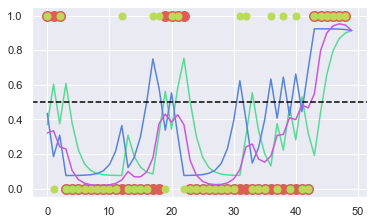

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
Pal = sns.color_palette('hls', 5)

# we need a different starting point because the bayes filter starts (before
# the first observation) from a naive prior, so the fitler and backward arrays
# have one less data point in them
ax.plot(state_ts[-49:], 'o', markersize=10, color=Pal[0])
ax.plot(obs_ts[-49:], 'o', markersize=7, color=Pal[1])

ax.plot(p1_fwd[-50:], linewidth=1.5, color=Pal[2])
ax.plot(p1_bkw[-50:], linewidth=1.5, color=Pal[3])
ax.plot(p1_smt[-50:], linewidth=1.5, color=Pal[4])

ax.axhline(0.5, linestyle='--', color='k', linewidth=1.5)

#### Now we can move onto the Baum Welch Reparameterization step

First we want to calcualte the matrix:

$$ \xi_{ij}(t) = \frac{\alpha_i(t) A_{ij} \beta_j(t+1) \tilde{B}_j(y_{t+1})}{\sum_{k, w = 1}^N \alpha_k(t) a_{kw} \beta_w(t + 1)\tilde{B}_w(y_{t+1}) } $$

Which has the same dimensions as $A$, so we can start with an empty matrix and populate it as wel go..


In [104]:
xi_mat = np.zeros((len(state_ts), A.shape[0], A.shape[1]))

# We want to calculate this matrix for all time values
for t in range(len(state_ts) - 1):
    # Loop over entries in A
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            xi_mat[t, i, j] = inf.forward_tracker[t][i] * A[i, j] * inf.backward_tracker[t+1][j] * B[obs_ts[t+1], j]

    # Now normalize
    denom = np.sum(xi_mat[t])
    xi_mat[t] /= denom


Now that we have the $\xi$ matrix, we have everything we need to update the estimation parameters:

- First, the initial state probability is updated
    $$ \pi_i^* = \gamma_i(t=1)$$
- Then, we update the elements of the hidden-state transition matrix (to the expected number of transitions from state $i\to j$ campared to the expected number of transitions away from state $i$, which includes self transitions)
    $$ a_{ij}^* = \frac{\sum_{t=0}^T\xi_{ij}(t)}{\sum_{t=0}^T \gamma_i(t)} $$
- Then, we calculate
    $$ \tilde{B}_i(v_k) \equiv \frac{\sum_{t=0}^T 1_{y_t = v_k}\gamma_i(t)}{\sum_{t=0}^T \gamma_i(t)} $$
- Where the indicator function is unity of $y_t = v_k$ and zero otherwise, so that the expected number of times that the output observations have been equal to $v_k$ while in state $i$, over the total number of expected times of the system being in state $i$.


In [117]:
# First, 
new_prior = inf.bayes_smoother[0]
new_A = np.zeros_like(A)
new_B = np.zeros_like(B)

for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        new_A[i, j] = np.sum(xi_mat[:, i, j]) / np.sum([s[i] for s in inf.bayes_smoother])
        new_B[i, j] = np.sum([s[i] for k, s in enumerate(inf.bayes_smoother[1:]) if obs_ts[k] == j]) / np.sum([s[i] for s in inf.bayes_smoother]) # I think this is right?

new_A

array([[0.82834612, 0.11809552],
       [0.10995344, 0.94773806]])

In [118]:
new_B

array([[0.70205917, 0.29602334],
       [0.31798419, 0.6799221 ]])

In [119]:
new_A /= np.sum(new_A, axis=0)
new_B /= np.sum(new_B, axis=0)


In [124]:
# So, we can write this maximization routine into a single function

def _calc_xi_matrix(
    A: np.ndarray, B: np.ndarray, inf: infer.MarkovInfer
) -> np.ndarray:

    num_ts = len(inf.forward_tracker) - 1

    xi_mat = np.zeros((num_ts, A.shape[0], A.shape[1]))

    # We want to calculate this matrix for all time values
    for t in range(num_ts):
        # Loop over entries in A
        for i in range(A.shape[0]):
            for j in range(A.shape[1]):
                xi_mat[t, i, j] = inf.forward_tracker[t][i] * A[i, j] * inf.backward_tracker[t+1][j] * B[obs_ts[t+1], j]

        # Now normalize
        denom = np.sum(xi_mat[t])
        xi_mat[t] /= denom
        return xi_mat


def _update_estimates(
    inf_obj: infer.MarkovInfer, xi_mat: np.ndarray, obs_ts: Iterable
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    new_prior = inf_obj.bayes_smoother[0]
    new_A = np.zeros((inf_obj.n_sys, inf_obj.n_sys))
    new_B = np.zeros_like(new_A)

    for i in range(new_A.shape[0]):
        for j in range(new_A.shape[1]):
            new_A[i, j] = np.sum(xi_mat[:, i, j]) / np.sum([s[i] for s in inf_obj.bayes_smoother])
            new_B[i, j] = np.sum([s[i] for k, s in enumerate(inf_obj.bayes_smoother[1:]) if obs_ts[k] == j]) / np.sum([s[i] for s in inf_obj.bayes_smoother]) # I think this is right?

    new_A /= np.sum(new_A, axis=0)
    new_B /= np.sum(new_B, axis=0)
    new_prior /= np.sum(new_prior)    

    return new_A, new_B, new_prior


def maximization(
    A_est: np.ndarray, B_est: np.ndarray, obs_ts: Iterable,
    inf_obj: infer.MarkovInfer
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    # Build the xi matrix
    xi_mat = _calc_xi_matrix(A_est, B_est, inf_obj)

    # Update the estimates
    A_est, B_est, prior = _update_estimates(inf_obj, xi_mat, obs_ts)
    return A_est, B_est, prior


In [125]:
# And we can codify the expectation steps as well into a single method:
def expectation(obs_ts: np.ndarray, A_est: np.ndarray, B_est: np.ndarray) -> infer.MarkovInfer:
    inf = infer.MarkovInfer(A_est.shape[0], B_est.shape[0])
    inf.forward_algo(obs_ts, A_est, B_est)
    inf.backward_algo(obs_ts, A_est, B_est)
    inf.bayesian_smooth(A_est)
    return inf


In [137]:
# Now we can start with a naive estimate and see if things tend to converge towards the 'true' matrix

A = np.array([[0.9, 0.1],[0.1, 0.9]])
B = np.array([[0.7, 0.3],[0.3, 0.7]])

A_est = np.array([[0.6, 0.4],[0.6, 0.4]])
B_est = np.array([[0.4, 0.6],[0.4, 0.6]])

model = dynamics.HMM(2, 2)
model.A = A
model.B = B

model.run_dynamics(500)

obs_ts = model.get_obs_ts()


In [142]:
# Now we can run this for a few iterations
A_tracker = []
B_tracker = []

A_cost = []
B_cost = []

for i in range(100):
    inf_obj = expectation(obs_ts, A_est, B_est)
    A_est, B_est, prior_est = maximization(A_est, B_est, obs_ts, inf_obj)
    A_tracker.append(A_est)
    B_tracker.append(B_est)

    A_cost.append(np.linalg.norm(A_est - A, ord=2))
    B_cost.append(np.linalg.norm(B_est - B, ord=2))

